In [1]:
from baseline_cnn import *

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

net=Nnet().to(computing_device)
net.apply(weights_init)

# Print the model
print(net)

#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(),lr = 0.001)

CUDA is supported
Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=1575, out_features=599, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=599, out_features=201, bias=True)
  )
)


In [5]:
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor()])
dataset = loader('train.csv','/datasets/cs154-fa19-public/',transform=transform)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [6]:
import copy

# Track the loss across training
total_loss = []
total_accu = []

train_losses = []
train_accuracies = []

avg_minibatch_loss = []
avg_minibatch_accu = []
N = 50

valid_losses = []
valid_accuracies = []
count_stop = 0

#Helper function for calculating accuracy
def calculate_accu(outputs, labels, batch_size):
    num_correct = torch.sum(torch.max(outputs, dim = 1)[1] == labels).item()
    return num_correct / batch_size

for epoch in range(50):
    
    N_minibatch_loss = 0.0
    N_minibatch_accu = 0.0
    
    total_loss = []
    total_accu = []

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print("mini_batch", minibatch_count)
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        accu = calculate_accu(outputs, labels, batch_size)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        total_accu.append(accu)
        
        N_minibatch_loss += loss
        N_minibatch_accu += accu
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            N_minibatch_accu /= N
            
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count+1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            avg_minibatch_accu.append(N_minibatch_accu)
            
            N_minibatch_loss = 0.0
            N_minibatch_accu = 0.0
    
    train_losses.append(np.average(total_loss))
    train_accuracies.append(np.average(total_accu))
    
    # TODO: Implement validation 
    with torch.no_grad():
        
        valid_loss = 0
        valid_accu = 0
        
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            
            #Apply current model to the data
            images, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(images)
            
            valid_accu += calculate_accu(outputs, labels, batch_size)
            valid_loss += criterion(outputs, labels).item()
        
        avg_valid_accu = valid_accu/minibatch_count
        avg_valid_loss = valid_loss/minibatch_count
        
        print("Valid loss for validation set is ", avg_valid_loss, ".")
        print("Accuracy for validation set is", avg_valid_accu * 100, "%.")

        if not valid_losses:
            # set the first network as the best model
            model = copy.deepcopy(net)
        elif avg_valid_loss > valid_losses[-1]:
            
            count_stop += 1
        elif avg_valid_loss < min(valid_losses):
            # Set the best model if the average valid loss is the lowest
            count_stop = 0
            model = copy.deepcopy(net)
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_accu)
        
    # Stop Training when validation loss goes up continuously
    if count_stop == 2:
            break

mini_batch 0
mini_batch 1
mini_batch 2
mini_batch 3
mini_batch 4
mini_batch 5
mini_batch 6
mini_batch 7
mini_batch 8
mini_batch 9
mini_batch 10
mini_batch 11
mini_batch 12
mini_batch 13
mini_batch 14
mini_batch 15
mini_batch 16
mini_batch 17
mini_batch 18
mini_batch 19
mini_batch 20
mini_batch 21
mini_batch 22
mini_batch 23
mini_batch 24
mini_batch 25
mini_batch 26
mini_batch 27
mini_batch 28
mini_batch 29
mini_batch 30
mini_batch 31
mini_batch 32
mini_batch 33
mini_batch 34
mini_batch 35
mini_batch 36
mini_batch 37
mini_batch 38
mini_batch 39
mini_batch 40
mini_batch 41
mini_batch 42
mini_batch 43
mini_batch 44
mini_batch 45
mini_batch 46
mini_batch 47
mini_batch 48
mini_batch 49
Epoch 1, average minibatch 50 loss: 5.187
mini_batch 50
mini_batch 51
mini_batch 52
mini_batch 53
mini_batch 54
mini_batch 55
mini_batch 56
mini_batch 57
mini_batch 58
mini_batch 59
mini_batch 60
mini_batch 61
mini_batch 62
mini_batch 63
mini_batch 64
mini_batch 65
mini_batch 66
mini_batch 67
mini_batch 68
mi

mini_batch 150
mini_batch 151
mini_batch 152
mini_batch 153
mini_batch 154
mini_batch 155
mini_batch 156
mini_batch 157
mini_batch 158
mini_batch 159
mini_batch 160
mini_batch 161
mini_batch 162
mini_batch 163
mini_batch 164
mini_batch 165
mini_batch 166
mini_batch 167
mini_batch 168
mini_batch 169
mini_batch 170
mini_batch 171
mini_batch 172
mini_batch 173
mini_batch 174
mini_batch 175
mini_batch 176
mini_batch 177
mini_batch 178
mini_batch 179
mini_batch 180
mini_batch 181
mini_batch 182
mini_batch 183
mini_batch 184
mini_batch 185
mini_batch 186
mini_batch 187
mini_batch 188
mini_batch 189
mini_batch 190
mini_batch 191
mini_batch 192
mini_batch 193
mini_batch 194
mini_batch 195
mini_batch 196
mini_batch 197
mini_batch 198
mini_batch 199
Epoch 2, average minibatch 200 loss: 2.473
mini_batch 200
mini_batch 201
mini_batch 202
mini_batch 203
mini_batch 204
mini_batch 205
mini_batch 206
mini_batch 207
mini_batch 208
mini_batch 209
mini_batch 210
mini_batch 211
mini_batch 212
mini_batch 2

mini_batch 295
mini_batch 296
mini_batch 297
mini_batch 298
mini_batch 299
Epoch 3, average minibatch 300 loss: 1.695
mini_batch 300
mini_batch 301
mini_batch 302
mini_batch 303
mini_batch 304
mini_batch 305
mini_batch 306
mini_batch 307
mini_batch 308
mini_batch 309
mini_batch 310
mini_batch 311
mini_batch 312
mini_batch 313
mini_batch 314
mini_batch 315
mini_batch 316
mini_batch 317
mini_batch 318
mini_batch 319
mini_batch 320
mini_batch 321
mini_batch 322
mini_batch 323
mini_batch 324
mini_batch 325
mini_batch 326
mini_batch 327
mini_batch 328
mini_batch 329
mini_batch 330
mini_batch 331
mini_batch 332
mini_batch 333
mini_batch 334
mini_batch 335
mini_batch 336
mini_batch 337
mini_batch 338
mini_batch 339
mini_batch 340
mini_batch 341
mini_batch 342
mini_batch 343
mini_batch 344
mini_batch 345
mini_batch 346
mini_batch 347
mini_batch 348
mini_batch 349
Epoch 3, average minibatch 350 loss: 1.664
mini_batch 350
mini_batch 351
mini_batch 352
mini_batch 353
mini_batch 354
mini_batch 355

mini_batch 59
mini_batch 60
mini_batch 61
mini_batch 62
mini_batch 63
mini_batch 64
mini_batch 65
mini_batch 66
mini_batch 67
mini_batch 68
mini_batch 69
mini_batch 70
mini_batch 71
mini_batch 72
mini_batch 73
mini_batch 74
mini_batch 75
mini_batch 76
mini_batch 77
mini_batch 78
mini_batch 79
mini_batch 80
mini_batch 81
mini_batch 82
mini_batch 83
mini_batch 84
mini_batch 85
mini_batch 86
mini_batch 87
mini_batch 88
mini_batch 89
mini_batch 90
mini_batch 91
mini_batch 92
mini_batch 93
mini_batch 94
mini_batch 95
mini_batch 96
mini_batch 97
mini_batch 98
mini_batch 99
Epoch 5, average minibatch 100 loss: 0.822
mini_batch 100
mini_batch 101
mini_batch 102
mini_batch 103
mini_batch 104
mini_batch 105
mini_batch 106
mini_batch 107
mini_batch 108
mini_batch 109
mini_batch 110
mini_batch 111
mini_batch 112
mini_batch 113
mini_batch 114
mini_batch 115
mini_batch 116
mini_batch 117
mini_batch 118
mini_batch 119
mini_batch 120
mini_batch 121
mini_batch 122
mini_batch 123
mini_batch 124
mini_bat

mini_batch 204
mini_batch 205
mini_batch 206
mini_batch 207
mini_batch 208
mini_batch 209
mini_batch 210
mini_batch 211
mini_batch 212
mini_batch 213
mini_batch 214
mini_batch 215
mini_batch 216
mini_batch 217
mini_batch 218
mini_batch 219
mini_batch 220
mini_batch 221
mini_batch 222
mini_batch 223
mini_batch 224
mini_batch 225
mini_batch 226
mini_batch 227
mini_batch 228
mini_batch 229
mini_batch 230
mini_batch 231
mini_batch 232
mini_batch 233
mini_batch 234
mini_batch 235
mini_batch 236
mini_batch 237
mini_batch 238
mini_batch 239
mini_batch 240
mini_batch 241
mini_batch 242
mini_batch 243
mini_batch 244
mini_batch 245
mini_batch 246
mini_batch 247
mini_batch 248
mini_batch 249
Epoch 6, average minibatch 250 loss: 0.620
mini_batch 250
mini_batch 251
mini_batch 252
mini_batch 253
mini_batch 254
mini_batch 255
mini_batch 256
mini_batch 257
mini_batch 258
mini_batch 259
mini_batch 260
mini_batch 261
mini_batch 262
mini_batch 263
mini_batch 264
mini_batch 265
mini_batch 266
mini_batch 2

In [9]:
torch.save(model, 'baseline_cnn.pt')

# Apply Model On the Test Dataset

In [7]:
#Create test set
test_dataset = loader('test.csv','/datasets/cs154-fa19-public/',
                      transform = transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size = batch_size)

## Test Set Preformance

In [8]:
#helper functions

#model for performance
def per_class_model_performance(performances):
    
    perf_df = []
    
    #for each class, calculate accuracy, recall, precision and bcr
    for i in range(len(performances)):
        
        cur_perf = performances[i]
        accu, recall, precision, bcr = get_per_class_values(cur_perf)
        
        perf_df.append([accu, precision, recall, bcr])
        
    #make it to a dataframe
    perf_df = pd.DataFrame(perf_df)
    perf_df.columns = ['Accuracy', 'Precision', 'Recall', 'BCR']
    
    return perf_df
 

#get measurement recall, accuracy, precision and bcr value for the current class
def get_per_class_values(cur_perf):    
    
    tp = cur_perf['TP']
    fp = cur_perf['FP']
    tn = cur_perf['TN']
    fn = cur_perf['FN']
    
    #accuracy
    accu = (tp + tn)/(tp + tn + fp + fn)
    
    #recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    #precision
    if fp + tp == 0:
        precision = 0
    else:
        precision = tp / (fp + tp)
        
    #bcr
    bcr = (precision + recall) / 2
    
    return accu, recall, precision, bcr

In [10]:
#Apply to test set and test Performances
all_class_performance = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(201):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test_loader, 0):
        
        print("current minibatch: ", minibatch_count)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = model(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(201):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracy = (test_accu/minibatch_count)

current minibatch:  0
current minibatch:  1
current minibatch:  2
current minibatch:  3
current minibatch:  4
current minibatch:  5
current minibatch:  6
current minibatch:  7
current minibatch:  8
current minibatch:  9
current minibatch:  10
current minibatch:  11
current minibatch:  12
current minibatch:  13
current minibatch:  14
current minibatch:  15
current minibatch:  16
current minibatch:  17
current minibatch:  18
current minibatch:  19
current minibatch:  20
current minibatch:  21
current minibatch:  22
current minibatch:  23
current minibatch:  24
current minibatch:  25
current minibatch:  26
current minibatch:  27
current minibatch:  28
current minibatch:  29
current minibatch:  30
current minibatch:  31
current minibatch:  32
current minibatch:  33
current minibatch:  34
current minibatch:  35
current minibatch:  36
current minibatch:  37
current minibatch:  38
current minibatch:  39
current minibatch:  40
current minibatch:  41
current minibatch:  42
current minibatch:  4

In [11]:
print('The test accuracy for the best model trained above is ' + str(test_accuracy * 100) + '%.')

The test accuracy for the best model trained above is 53.6875%.


In [12]:
perf_df = per_class_model_performance(all_class_performance)
perf_df.to_csv('baseline_performance.csv')

In [13]:
#Top 5 accuracies
perf_df.sort_values(by = 'Accuracy').head()

,Accuracy,Precision,Recall,BCR
188,0.985167,0.203704,0.687500,0.445602
22,0.985785,0.340909,0.468750,0.404830
109,0.987021,0.388889,0.700000,0.544444
93,0.987021,0.355556,0.551724,0.453640
37,0.987948,0.333333,0.300000,0.316667


In [15]:
perf_df.sort_values(by = 'Accuracy', ascending = False)[1:6]

,Accuracy,Precision,Recall,BCR
199,0.999382,0.833333,0.833333,0.833333
91,0.999382,1.000000,0.714286,0.857143
130,0.999073,0.900000,0.818182,0.859091
183,0.998764,0.625000,0.833333,0.729167
196,0.998764,1.000000,0.500000,0.750000


In [18]:
perf_df.describe().loc['mean', :]

Accuracy     0.995332
Precision    0.589697
Recall       0.507473
BCR          0.548585
Name: mean, dtype: float64

## Visualizations

In [19]:
import matplotlib.pyplot as plt

### Training and Validation Loss Curves

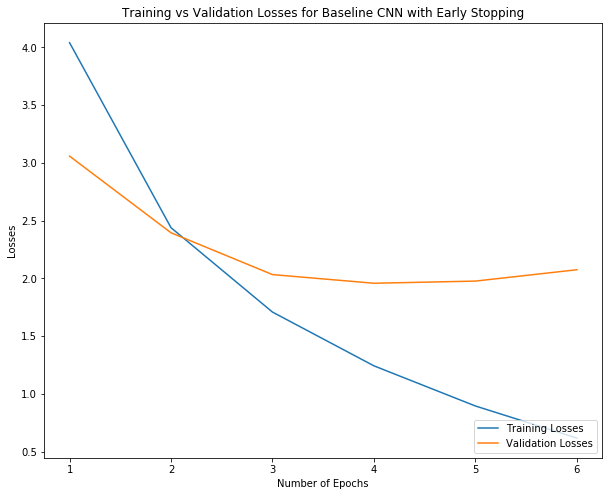

In [20]:
graph_title = 'Training vs Validation Losses for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('baseline_train_vad_loss.png')

### Plot on Training and Testing Accuracy Curves

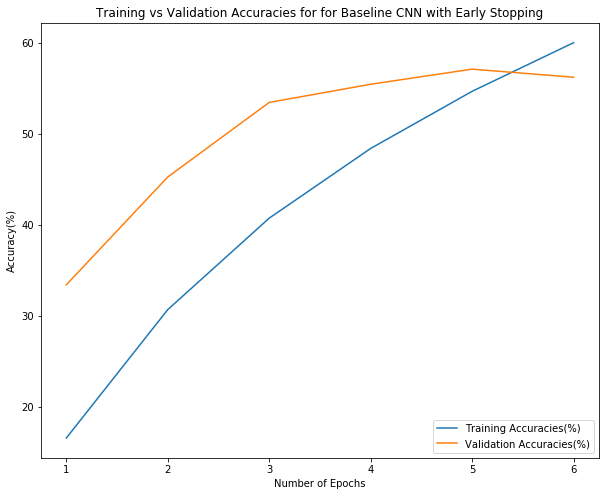

In [23]:
graph_title = 'Training vs Validation Accuracies for for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accuracies) + 1), np.array(train_accuracies) * 100, label='Training Accuracies(%)')
ax.plot(np.arange(1, len(valid_accuracies) + 1), np.array(valid_accuracies) * 100, label='Validation Accuracies(%)')
ax.set(xlabel='Number of Epochs', ylabel='Accuracy(%)',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('baseline_train_test_accu.png')

### Filter Maps

In [21]:
for idx, m in enumerate(model.modules()):
    print(idx, '->', m)

0 -> Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=1575, out_features=599, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=599, out_features=201, bias=True)
  )
)
1 -> Sequential(
  (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1,

In [22]:
filter_imgs = []
# Get the weights for each needed filter
for idx, m in enumerate(model.modules()):
    if idx == 2:     
        #early filters
        early = (m.weight.cpu().data.numpy()[1])[0]  
        early2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(early)
        filter_imgs.append(early2)
        
    if idx == 4:
        # middle filters
        middle = (m.weight.cpu().data.numpy()[1])[0]
        middle2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(middle)
        filter_imgs.append(middle2)
    
    if idx == 7:
        # late filters
        late = (m.weight.cpu().data.numpy()[1])[0]
        late2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(late)
        filter_imgs.append(late2)
        break 

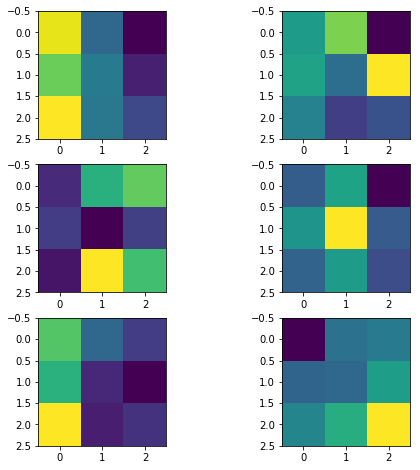

In [23]:
fig = plt.figure(figsize=(8, 8))
cols = 2
rows = 3

for i in range(1, cols * rows + 1):
    img = filter_imgs[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    
plt.savefig('baseline_filter.png')